# Document to generate figures for paper on Auditory Streaming Complexity

Scripts to generate figures for the paper with Julie Cumming. Built off of scripts from Masses_Comp_stats etc.

-> post this! https://reproducible-science-curriculum.github.io/sharing-RR-Jupyter/01-sharing-github/

In [1]:
import music21 as m21
import copy
import sys
import os
import time

import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from collections import OrderedDict
import pickle

import pingouin as pg


# Definitions

In [2]:
# new definitinos for processing streams that deal better with triple meter issues

def Onset_List(m21stream):
    # this function returns the timepoints of note onsets (in score time, beats)
    # reduced to a list of unique timepoints
    allOns = []
    # first: is this a score?   
    if isinstance(m21stream,m21.stream.Score):  
        # retreive all note onsets from score
        for p in m21stream:
            if isinstance(p,m21.stream.Part):
                ons = Onset_List(p)
                allOns.extend(ons)
    if isinstance(m21stream,m21.stream.Part):
        flattenedp = m21stream.flat.notesAndRests
        rest_state = 0
        tie_state = 0
        for el in flattenedp:
            if isinstance(el,m21.note.Note):
                rest_state = 0
                if el.tie:
                    if el.tie.type == 'start':
                        allOns.append(float(el.offset))
                else:
                    allOns.append(float(el.offset))
            if isinstance(el,m21.note.Rest):
                if rest_state == 0:
                    # allOns.append(float(el.offset)) Don't include rest onsets
                    rest_state = 1
        allOns.append(float(el.offset+el.quarterLength)) # end of last note or rest     
    # extract unique time values
    ons = np.unique(allOns)
    return ons

def Diatonic_Number(note):
    # translates a music21 note element to it's number in diatonic values, 
    # instead of chromatic like midi
    diatonic = {'C':0,'D':1,'E':2,'F':3,'G':4,'A':5,'B':6}
    dPitch = diatonic[note.name[0]] + 7 + note.octave*7
    return dPitch

def Onset_Pitch_List(m21part):
    # this function returns the timepoints and pitch of note onsets (in score time, beats) for parts
    # counts notes only as their diatonic numbers, not midi chromatic values
    # forcing el.offset and el.quarterlength to floats for indexing purposes
    ons = [[],[]]
    # input must be a part
    if isinstance(m21part,m21.stream.Part):    
        # retreive all note onsets from score
        flattenedp = m21part.flat.notesAndRests
        rest_state = 0
        for el in flattenedp:
            if isinstance(el,m21.note.Note):
                rest_state = 0
                if el.tie:
                        if el.tie.type == 'start':
                            ons[0].append(float(el.offset))
                            #ons[1].append(el.pitch.ps)
                            ons[1].append(Diatonic_Number(el))
                else:
                    ons[0].append(float(el.offset))
                    #ons[1].append(el.pitch.ps)
                    ons[1].append(Diatonic_Number(el))
            if isinstance(el,m21.note.Rest):
                 if rest_state == 0:
                    ons[0].append(float(el.offset)) 
                    ons[1].append(math.nan)
                    rest_state = 1
        ons[0].append(float(el.offset+el.quarterLength))
        ons[1].append(math.nan)
    return ons

def beat_Times(score):
    # generate complete beatTimes list for interpolated pitch sequences and melodies
    onsAll = Onset_List(score)
    step = np.min(np.diff(onsAll))
    if np.min(np.diff(onsAll))<1:
        step = np.min([np.min(np.diff(onsAll)),1-np.min(np.diff(onsAll))])
    rate_options = [8,6,4,3,2,1,0.5,0.25,0.125] # heavy handed fix of the rates to covenient beat values
    close_rate =np.argmin(abs(rate_options -(1/step)))
    new_step = 1/rate_options[close_rate]
    beatTime = np.arange(onsAll[0],onsAll[-1]+new_step,new_step)
    return beatTime    

def Pitch_Beat_Interpolate(onsets,pitchValues,beatTime):
    # function to produce pitch sequence at times beatTime from onset list with corresponding pitch values
    # apparently this kind of interpolation isn't an option in pandas?!
    # first align min values
    if onsets[0]>beatTime[0]:
        onsets = beatTime[0] + onsets
        pitchValues = math.nan + pitchValues
    beatTime_pitch = np.array(np.zeros_like(beatTime), dtype=np.float)
    onsets_h = np.array(onsets)
    for i_beats in range(len(beatTime)):
        r = np.max(np.where(onsets_h<=beatTime[i_beats]))
        beatTime_pitch[i_beats] = pitchValues[np.max(np.where(onsets_h<=beatTime[i_beats]))]
    return beatTime_pitch

def Score_Pitch_Steps(score):
    # from an m21 score, evaluate the pitch squence in each part and outputs
    # panda dataframe with colums of current pitch values for even sampling (on smallest subdivision)
    df_Score = pd.DataFrame()
    if isinstance(score,m21.stream.Score):  
        beatTime = beat_Times(score)
        df_Score = pd.DataFrame(index=beatTime)
        #df_Score['time'] = beatTime 
        #then run through all parts to first extract onsets and then build sequence
        k = 1
        for part in score:
            if isinstance(part,m21.stream.Part):
                if part.partName is None:
                    pn = 'Voice_' +str(k)
                    k+=1
                else:
                    pn = part.partName.strip('"')
                    if pn.startswith('Voice'):
                        pn = 'Voice_' +str(k)
                        k+=1
                onsets = Onset_Pitch_List(part)
                df_Score[pn] = Pitch_Beat_Interpolate(onsets[0],onsets[1],beatTime)
    return df_Score

def Line_Seperation(score):
    # cues to blend: co entry (++), co-onsets, co-direction (comodulation)
    # count up from bass, who shares with them?
    df_pitchs = Score_Pitch_Steps(score)
    beatwise = df_pitchs
    beatwise = beatwise.fillna(-25) # CHEAT to catch entries, assuming here no voice leaps more than two octaves
    beatwise = beatwise.diff()
    beatwise = beatwise.mask(beatwise>25,math.nan) # Mark entries with nan(cheat)
    beatwise = beatwise.mask(beatwise<-25,0) # ignore ends of lines (cheat)
    beatwise = beatwise.mask(beatwise>0,1) # equate all increases
    beatwise = beatwise.mask(beatwise<0,-1) # equate all decreases
    beatwise = beatwise.fillna(2) # Distinguish entries by replacing nan with a higher values than changes in pitch
    beatwise = beatwise.mask(df_pitchs.isna(),math.nan) # reapply nan values where voices are quiet
    df_seperate = beatwise

    #returned columns of voice seperationg actions, with coaction attributed to highest active voice. Entries 1, other actions contribute 0.5
    # note: onsets counted only if with melodic motion.
    return df_seperate


def Voice_Seperation(score):
    df_seperate = Line_Seperation(score)

    # for each voice, if voice seperation cues match those of a higher voice(s), make NA
    # or rather subtractive counting of independent streams, allowing for two or more voices per stream
    parts = df_seperate.columns
    for i in range(len(parts)-1):
        for j in range(i+1,len(parts)):
            df_seperate[parts[j]] = df_seperate[parts[j]].mask(df_seperate[parts[j]]==df_seperate[parts[i]],math.nan)
    df_seperate = 0.5*df_seperate.abs()
    
    #returned columns of voice seperationg actions, with coaction attributed to highest active voice. Entries 1, other actions contribute 0.5
    # note: onsets counted only if with melodic motion.
    return df_seperate



def Comp_Decay(series,beat_decay_slope):
    # Assume evenly sampled index of series
    A = series.fillna(0)
    B = series
    step = np.min(np.diff(series.index))
    # ar values
    ar = -(beat_decay_slope*step)*np.arange(0,1./beat_decay_slope,step)
    # smoothing without negatives
    for i in range(len(ar)):
        shifted = B.shift(periods=i+1,fill_value=0) + ar[i]
        shifted = shifted.mask(shifted<0,0)
        A += shifted.fillna(0)
        A = A.mask(A<0,0)
    return A

def Stream_Complexity_Smoothed(score):
    # smoothing voice seperation per line (highest) and calculating total
    #   With 8 beat linear decay extension of independence for entries
    #   And 4 beat linear decay extention of independence for distinct onset or direction of motion
    df_seperate = Voice_Seperation(score)
    A = Comp_Decay(df_seperate,0.2)

    # max and min the seperation intervals of each voice from the whole
    A = A.mask(A>1,1)
    A = A.mask(A==0,0)
    # fill in the sustaining whole for the total
    B = A
    B = B.mask(df_seperate==0,1)
    C = B.sum(1)
    C= C.mask(C==0,math.nan)
    C = C.mask(C<1,1)
    C = C.mask(C.isna(),0)
    A['Total'] = C
    return A

# now for onset only measure of seperation
def Event_Beat_Interpolate(events,beatTime):
    # fit onset list into beatTime sequence
    beatTime_es = np.array(np.zeros_like(beatTime), dtype=np.float)
    beatTime_es.fill(np.nan)
    for es in events:
        i = np.max(np.where(beatTime<=es))
        beatTime_es[i] = 1
    return beatTime_es


# voice count description  for every piece!! woo hoo!!

def Voice_Count(score):
    df_pitch = Score_Pitch_Steps(score)
    # get the number of voices active per moment 
    df_pitch = df_pitch.mask(df_pitch>1,1)
    df_pitch = Comp_Decay(df_pitch,0.2)
    df_pitch = df_pitch.mask(df_pitch>1,1)
    df_pitch = df_pitch.mask(df_pitch.isna(),0)
    df_active = df_pitch.sum(1)
    return df_active

def Distribution_Functions(A):
    # A is a single column pandas series
    # output pandas series with column 1: df, column 2: cdf
    # get cdf of total 
    Fcnt = Counter()
    for c in A:
        r=np.around(c,2)
        Fcnt[r]+=1
    dist_values = sorted(list(OrderedDict.fromkeys(np.around(A,2))))
    cdf_A = pd.DataFrame(index=dist_values)
    B = []
    C = []
    L = float(len(A))
    for i in range(len(dist_values)):
        B.append(Fcnt[dist_values[i]]/L)
        C.append(np.sum(B))
    cdf_A['df'] = B
    cdf_A['cdf'] = C
    return cdf_A

def Onset_Cues(score):
    beatTime = beat_Times(score)
    df_Score = pd.DataFrame(index=beatTime)
    k = 1
    for part in score:
        if isinstance(part,m21.stream.Part):
            pn = 'Voice_' + str(k)
            df_Score[pn] = Event_Beat_Interpolate(Onset_List(part),beatTime)
            k+=1
    df_seperate = df_Score.fillna(0)
    return df_seperate

def Motion_Cues(score):
    # cues to blend: co entry (++), co-onsets, co-direction (comodulation)
    # count up from bass, who shares with them?
    df_pitchs = Score_Pitch_Steps(score)
    beatwise = df_pitchs
    beatwise = beatwise.fillna(-25) # CHEAT to catch entries, assuming here no voice leaps more than two octaves
    beatwise = beatwise.diff()
    beatwise = beatwise.mask(beatwise>25,math.nan) # Mark entries with nan(cheat)
    beatwise = beatwise.mask(beatwise<-25,0) # ignore ends of lines 
    beatwise = beatwise.mask(beatwise>0,1) # equate all increases
    beatwise = beatwise.mask(beatwise<0,-1) # equate all decreases
    beatwise = beatwise.fillna(0) # remove entries by replacing nan with 0 
    beatwise = beatwise.mask(df_pitchs.isna(),math.nan) # reapply nan values where voices are quiet
    df_seperate = beatwise

    #returned columns of voice seperationg actions, with coaction attributed to highest active voice. Entries 1, other actions contribute 0.5
    # note: onsets counted only if with melodic motion.
    return df_seperate

def Entry_Cues(score):
    # cues to blend: co entry (++), co-onsets, co-direction (comodulation)
    # count up from bass, who shares with them?
    df_pitchs = Score_Pitch_Steps(score)
    beatwise = df_pitchs
    beatwise = beatwise.fillna(-25) # CHEAT to catch entries, assuming here no voice leaps more than two octaves
    beatwise = beatwise.diff()
    beatwise = beatwise.mask(beatwise>25,math.nan) # Mark entries with nan(cheat)
    beatwise = beatwise.mask(beatwise<20,0) # ignore ends of lines (cheat)
    beatwise = beatwise.fillna(2) # Distinguish entries by replacing nan with a higher values than changes in pitch
    beatwise = beatwise.mask(df_pitchs.isna(),math.nan) # reapply nan values where voices are quiet
    df_seperate = 0.5*beatwise
    #returned columns of voice seperationg actions, with coaction attributed to highest active voice. Entries 1, other actions contribute 0.5
    # note: onsets counted only if with melodic motion.
    return df_seperate

def Cue_Reduction(df_C):
    # for each voice, if voice seperation cues match those of a higher voice(s), make NA
    # or rather subtractive counting of independent streams, allowing for two or more voices per stream
    df_seperate = pd.DataFrame(index=df_C.index)
    parts = df_C.columns
    for i in range(len(parts)):
        df_seperate[parts[i]] = df_C[parts[i]]
    for i in range(len(parts)-1):
        for j in range(i+1,len(parts)):
            df_seperate[parts[j]] = df_seperate[parts[j]].mask(df_seperate[parts[j]]==df_seperate[parts[i]],math.nan)
    #df_seperate = 0.5*df_seperate.abs()
    df_seperate = df_seperate.fillna(0)
    return df_seperate

def All_Cues(score):
        # Onsets
    df_seperate  = Onset_Cues(score) 
    
    # Pitch changes (with a reduction to remove reduncancy with onsets)
    df_C = Motion_Cues(score).abs()
    df_seperate = df_seperate.mask(df_C.abs()>0,0)
    df_seperate = 0.25*df_seperate + 0.5*df_C.abs()
    
    # Entries (with a reduction to removed redundances with onsets)
    df_seperate += Entry_Cues(score) # entries get twice the weight as other cues
    df_seperate = df_seperate.mask(df_seperate>1,1)

    # integrate successive cues and allow them decay time
    df_streams = Comp_Decay(df_seperate,0.2) # reduction linear over 4 steps
    df_seperate = df_streams.mask(df_streams>1,1) # capt contributions per stream
    

    return df_seperate

def All_Cues_Reduced(score):
    # TODO check if it is a score (m21 datatype) with multiple parts
    
    # calculate the streaming effect of this combination of cues 
    # Onsets
    df_C = Onset_Cues(score)
    df_seperate = Cue_Reduction(df_C)
    
    # add Pitch changes (with a reduction to remove reduncancy with onsets)
    df_C = Motion_Cues(score)
    df_seperate = df_seperate.mask(df_C.abs()>0,0)
    df_seperate = 0.25*df_seperate + 0.5*Cue_Reduction(df_C).abs()

    # Entries (with a reduction to removed redundancies with onsets)
    df_C = Entry_Cues(score)
    df_seperate = Cue_Reduction(df_C) + df_seperate # entries get twice the weight as other cues
    df_seperate = df_seperate.mask(df_seperate>1,1)

    # integrate successive cues and allow them decay time
    df_streams = Comp_Decay(df_seperate,0.2) # reduction linear over 4 steps
    df_streams = df_streams.mask(df_streams>1,1) # capt contributions per stream
    
    return df_streams

def Streaming(score):
    # TODO check if it is a score (m21 datatype) with multiple parts
    
    # get reduced stream cues for all voices
    df_streams = All_Cues_Reduced(score)
    
    # find min streams WITH 1 held line if present
    df_sounds = Score_Pitch_Steps(score)       
    # B this series knows where the voices are silent. OK
    df_B = df_sounds.mask(df_sounds.isna(),0)
    B = df_B.sum(1)
    B =  B.mask(B==0,math.nan) 
    
    df_sounds = df_sounds.mask(df_sounds>1,0) # all times sounding is zero. 
    df_sounds += df_streams # add all the cues
    parts = df_sounds.columns 
    for i in range(len(parts)-1): # reduce the shared held parts to highest voice
        for j in range(i+1,len(parts)):
            df_sounds[parts[j]] = df_sounds[parts[j]].mask(df_sounds[parts[j]]==df_sounds[parts[i]],math.nan)
    # now all the zeros are the top held voice, but the cues are messed up
    df_sounds = df_sounds.mask(df_sounds>0,math.nan) # remove remaining cues
    df_sounds = df_sounds.mask(df_sounds==0,2) # isolate held lines above
    df_sounds = df_sounds.mask(df_sounds.isna(),0) # set
    df_sounds += df_streams # now the min voices are active, cues and held
    df_sounds = df_sounds.mask(df_sounds==0,math.nan) # remove the extraneous zeros
    df_sounds = df_sounds.mask(df_sounds==2,0)

    C = df_streams.sum(1) - df_sounds.min(1) + 1 # replace the least active "distinct" voice with 1

    C = C.mask(C<1,1)
    C = C.mask(B.isna(),math.nan)
    df_streams['Total'] = C
    
    return df_streams

def Streaming_2(score):
    # TODO check if it is a score (m21 datatype) with multiple parts
    df_streams = All_Cues_Reduced(score)
    # find min streams WITH 1 held line if present
    
    df_sounds = Score_Pitch_Steps(score)       
    # B this series knows where the voices are silent. OK
    df_B = df_sounds.mask(df_sounds.isna(),0)
    B = df_B.sum(1)
    B =  B.mask(B==0,math.nan) 
    
    df_sounds = df_sounds.mask(df_sounds>1,0) # all times sounding is zero. 
    df_sounds += df_streams # add all the cues
    parts = df_sounds.columns 
    for i in range(len(parts)-1): # reduce the shared held parts to highest voice
        for j in range(i+1,len(parts)):
            df_sounds[parts[j]] = df_sounds[parts[j]].mask(df_sounds[parts[j]]==df_sounds[parts[i]],math.nan)
    # now all the zeros are the top held voice, but the cues are messed up
    df_sounds = df_sounds.mask(df_sounds>0,math.nan) # remove remaining cues
    df_sounds = df_sounds.mask(df_sounds==0,2) # isolate held lines above
    df_sounds = df_sounds.mask(df_sounds.isna(),0) # set
    df_sounds += df_streams # now the min voices are active, cues and held
    df_sounds = df_sounds.mask(df_sounds==0,math.nan) # remove the extraneous zeros
    df_streams = df_sounds.mask(df_sounds==2,0.25) # held notes are given some value but not a full stream

    C = df_streams.sum(1) - df_streams.max(1) + 1 # replace most active "distinct" voice with 1

    C = C.mask(C<1,1)
    C = C.mask(B.isna(),math.nan)
    df_streams['Total'] = C
    
    return df_streams

# plot analysis of music

In [3]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
f='Jos0802a-Missa_Fortuna_desperata-Kyrie.krn'
score = m21.converter.parse(f)
sc = m21.converter.parse(f)
os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')

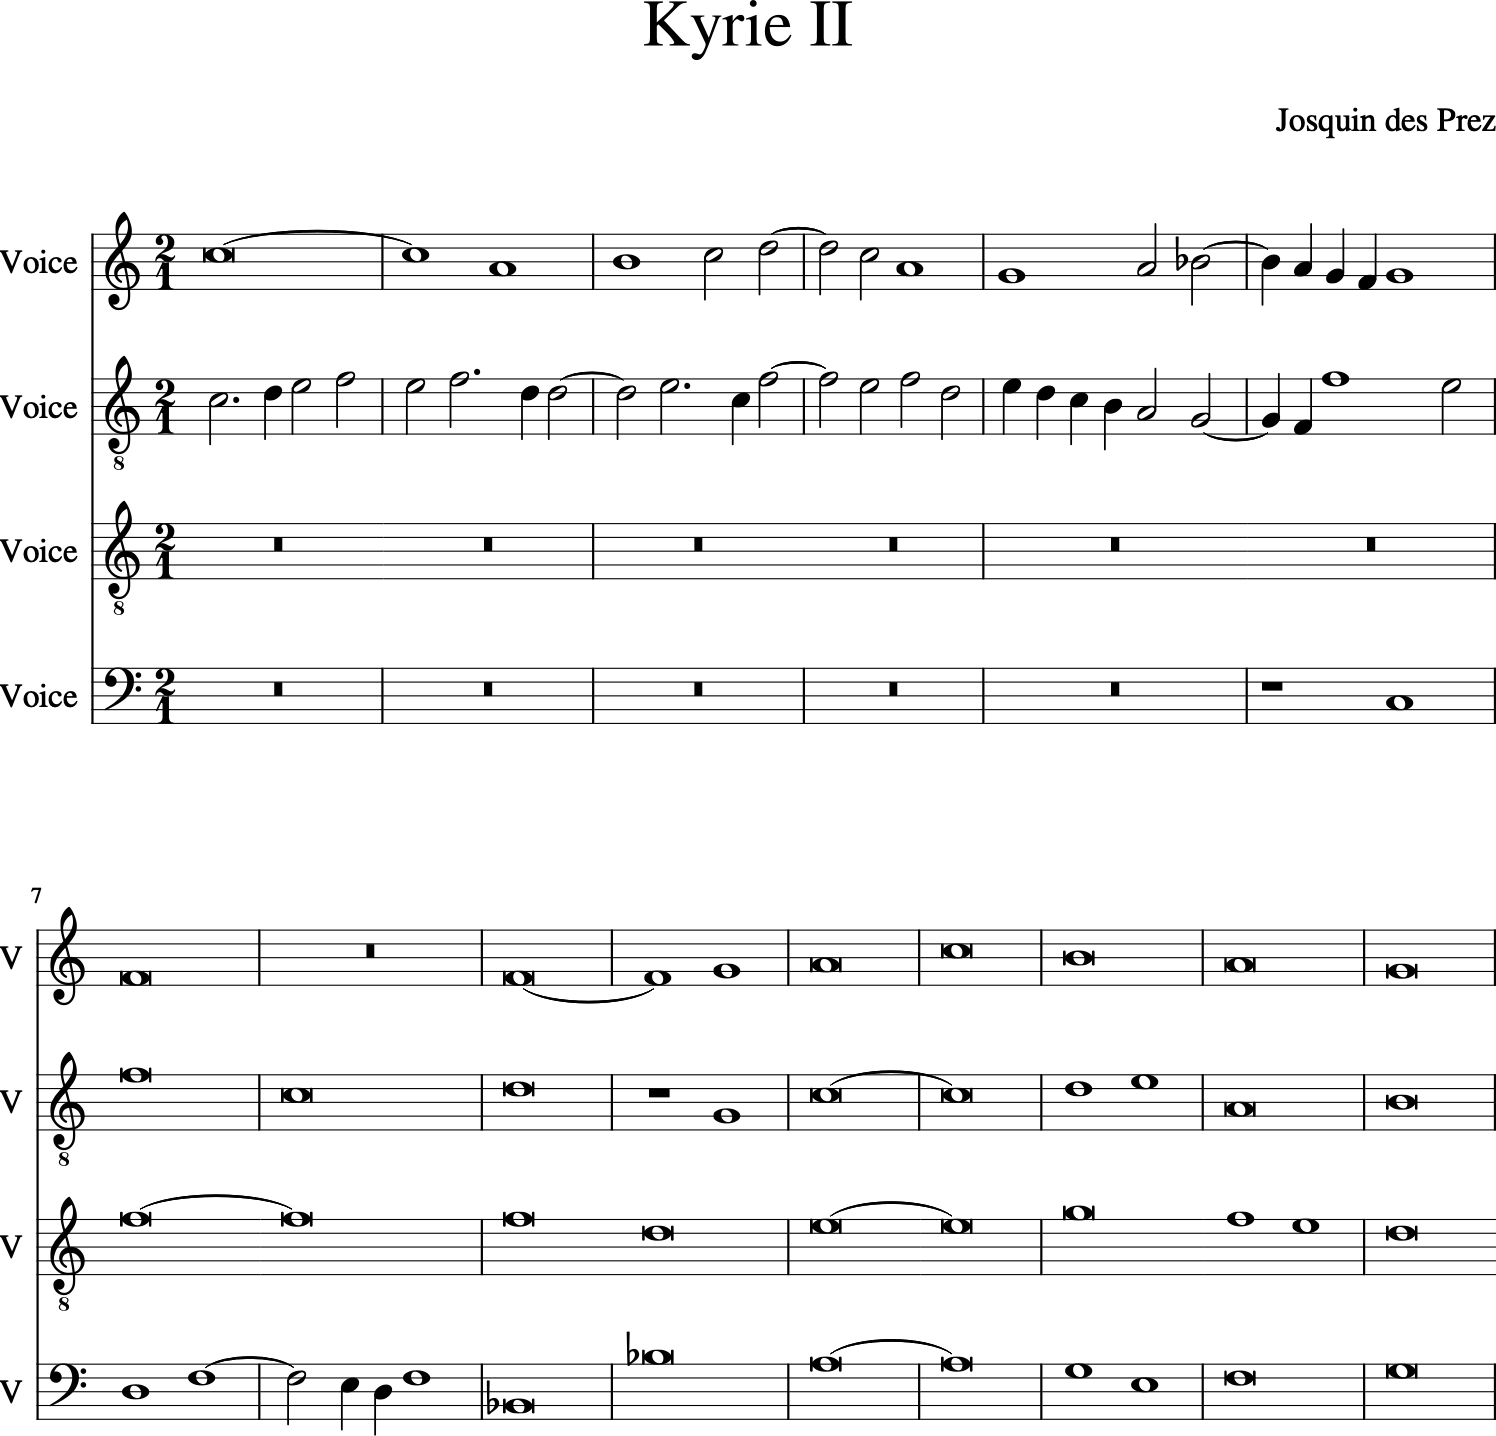

In [4]:
#score.show()
score = sc.measures(16, 30)
score.show()

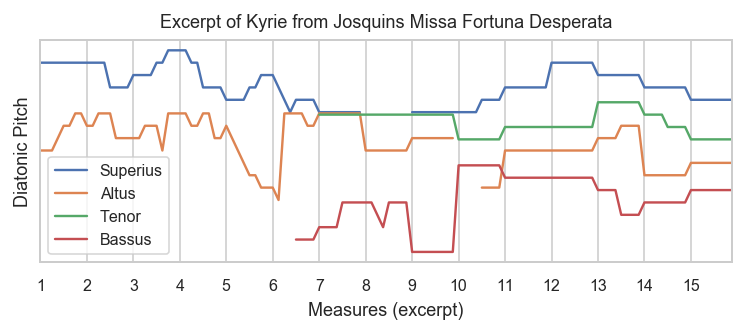

In [5]:
sns.set_context("paper")

# plot of polyphony excerpt 
df_pitchs = Score_Pitch_Steps(score)
x_r = np.array([0,119])

fig= plt.figure(figsize=(6,2.2))
sns.set_style("whitegrid")
axes= fig.add_axes([0.1,0.2,0.8,0.7])
clabels = df_pitchs.columns
for i in range(len(clabels)):    
    axes.plot(df_pitchs[clabels[i]]+-.1*i)
step = np.min(np.diff(df_pitchs.index))
#plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius', 'Altus', 'Tenor','Bassus'),fontsize=8)
axes.set_yticks([])
axes.xaxis.set_ticks(np.arange(0,118,8))
axes.xaxis.set_ticklabels(np.arange(1,16),fontsize=8)
plt.xlabel('Measures (excerpt)',fontsize=9)
plt.ylabel('Diatonic Pitch',fontsize=9)
plt.title('Excerpt of Kyrie from Josquin''s Missa Fortuna Desperata',fontsize=9)

axes.set_xbound(lower=x_r[0], upper=x_r[1])
plt.savefig("pitch_1.png",dpi = 400)
plt.show()


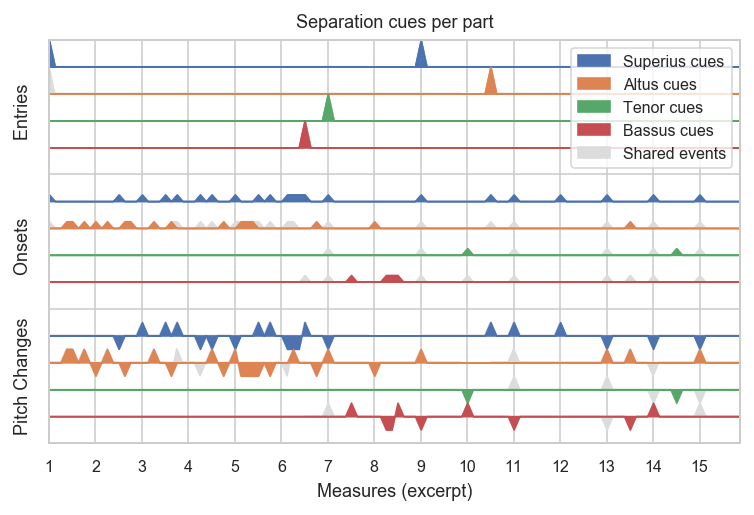

In [6]:
sns.set_context("paper")
# individual cues from this excerpt: ENTRY CUES
x_r = np.array([0,119])
fig= plt.figure(figsize=(6,3.5))
sns.set_style("whitegrid")
axes= fig.add_axes([0.1,0.15,0.8,0.8])
df_cues = Entry_Cues(score)
df_seperated = Cue_Reduction(df_cues)
offset = 14
for i in range(4):    
    axes.fill_between(df_seperated.index,df_seperated['Voice_'+str(i+1)]+offset-i,offset-i,color='C'+str(i))
for i in range(4): 
    axes.fill_between(df_cues.index,df_cues['Voice_'+str(i+1)]+offset-i,offset-i,color='gainsboro')
for i in range(4):    
    axes.fill_between(df_seperated.index,df_seperated['Voice_'+str(i+1)]+offset-i,offset-i,color='C'+str(i))

    
df_cues = 0.25*Onset_Cues(score)
df_seperated = Cue_Reduction(df_cues) 
offset = 9
for i in range(4): 
    axes.fill_between(df_cues.index,df_cues['Voice_'+str(i+1)]+offset-i,offset-i,color='gainsboro')
for i in range(4):    
    axes.fill_between(df_seperated.index,df_seperated['Voice_'+str(i+1)]+offset-i,offset-i,color='C'+str(i))

df_cues = 0.5*Motion_Cues(score)
df_seperated = Cue_Reduction(df_cues) 
offset = 4
for i in range(4): 
    axes.fill_between(df_cues.index,df_cues['Voice_'+str(i+1)]+offset-i,offset-i,color='gainsboro')
for i in range(4):    
    axes.fill_between(df_seperated.index,df_seperated['Voice_'+str(i+1)]+offset-i,offset-i,color='C'+str(i))
   
    
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.set_ybound(lower=0, upper=15)
axes.yaxis.set_ticks([5,10,15])   
axes.yaxis.set_ticklabels(['Pitch Changes   ','Onsets          ','Entries          '],rotation=90,fontsize=9)
axes.xaxis.set_ticks(np.arange(0,118,8))
axes.xaxis.set_ticklabels(np.arange(1,16),fontsize=8)
plt.xlabel('Measures (excerpt)',fontsize=9)
#plt.ylabel('All Cues')
plt.title('Separation cues per part',fontsize=9)

#plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius cues', 'Altus cues', 'Tenor cues','Bassus cues','Shared events'),loc=1,fontsize=8)
plt.savefig("cues_Each_1.png",dpi = 400)
plt.show()

In [ ]:
# all the cues together
sns.set_context("paper")
df_cues = All_Cues(score)
df_seperated = All_Cues_Reduced(score)

sns.set_style("whitegrid")
fig= plt.figure(figsize=(6,2.7))
axes= fig.add_axes([0.1,0.2,0.8,0.7])

axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.fill_between(df_cues.index,df_cues['Voice_1']+3,3,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_2']+2,2,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_3']+1,1,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_4'],0,color='gainsboro')
axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.xaxis.set_ticks(np.arange(0,118,8))
axes.xaxis.set_ticklabels(np.arange(1,16),fontsize=8)
axes.set_yticks([])
plt.xlabel('Measures (excerpt)',fontsize=9)
plt.ylabel('Integrated cues',fontsize=9)
plt.title('Integrated separation cues per part',fontsize=9)
#plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius cues', 'Altus cues', 'Tenor cues','Bassus cues','Shared events'),loc=3,fontsize=8)
plt.savefig("cues_1.png",dpi = 400)
plt.show()

In [ ]:
sns.set_context("paper")
A =  Voice_Count(score)
print(A.mean())
df_seperated = Streaming_2(score)

x_r = np.array([0,119])
fig= plt.figure(figsize=(6,2.2))
axes= fig.add_axes([0.1,0.2,0.8,0.7])

sns.set_style("whitegrid")
axes.plot(A,color='darkred',linewidth=2)
axes.fill_between(df_seperated.index,df_seperated['Total'],0,color="c")
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.xaxis.set_ticks(np.arange(0,118,8))
axes.xaxis.set_ticklabels(np.arange(1,16),fontsize=8)
plt.xlabel('Measures (excerpt)',fontsize=9)
locs, labels = plt.yticks(np.arange(0, 5, step=1),fontsize=8)
#plt.grid(color='k', linestyle=':', linewidth=1)
plt.ylabel('Streams',fontsize=9)
axes.legend(('Voices Active', 'Streaming'),fontsize=8)
plt.title('Number of Voices Active and Total Streaming Complexity',fontsize=9)

plt.savefig("Streams_1.png",dpi = 400)
plt.show()

print(df_seperated.mean())
print(A.index[-1])

In [ ]:
sns.set_context("paper")

# Mean values of voices counts per movement 

# os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
# f='Jos0802a-Missa_Fortuna_desperata-Kyrie.krn'
# #f='Jos0802b-Missa_Fortuna_desperata-Gloria.krn'
# score = m21.converter.parse(f)
# os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')

score = sc
A =  Voice_Count(score)
df_seperated = Streaming_2(score)
x_r = [df_seperated.index[0],df_seperated.index[-1]]

left, width = 0.08, 0.75
bottom, height = 0.2, 0.65
spacing = 0.005
miniWidth = 0.06

rect_series = [left, bottom, width, height]
rect_hist1 = [left + width + spacing, bottom, miniWidth, height]
rect_hist2 = [left + width + spacing + miniWidth + spacing, bottom, miniWidth, height]

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_style("whitegrid")
ax = fig.add_axes(rect_series)
ax.plot(A,color='darkred',linewidth=2)
ax.fill_between(df_seperated.index,df_seperated['Total'],0,color="c")
ax.set_xbound(lower=x_r[0], upper=x_r[1])
ticks = np.arange(x_r[0],x_r[1],32)
ax.yaxis.set_ticks(np.arange(0, 6, step=1))
ax.yaxis.set_ticklabels(np.arange(0, 6, step=1),fontsize=8)
ax.xaxis.set_ticks(ticks)
ax.xaxis.set_ticklabels(np.arange(1,len(ticks)*4,4),fontsize=8)
plt.xlabel('Measures',fontsize=9)
ax.legend(('Voices Active', 'Streaming Complexity'),fontsize=8)
plt.ylabel('Streams',fontsize=9)

plt.title('Voices Active and Total Streaming for Missa Fortuna Desperata, Kyrie',fontsize=9)


df_A = pd.DataFrame(dict(x = [],g = []))
df = pd.DataFrame(dict(x=A, g='Voices Active'))
df_A = df_A.append(df, ignore_index=True)

sns.set_style("darkgrid")
ax_hist1 = fig.add_axes(rect_hist1, sharey=ax)
ax_hist1.plot(0,A.mean(),color ='black', marker="D", markersize=5)               
sns.violinplot(x='g', y='x',data=df_A, width=1,palette="Reds",bw=.05,inner='quartile')
ax_hist1.tick_params(axis="y", labelleft=False)
ax_hist1.set_xbound(lower=-1, upper=1)
plt.title('          Distributions',fontsize=9)
ax_hist1.set_xticklabels(['Voices'],fontsize=9)
ax_hist1.tick_params('x',labelsize=8,labelrotation = 30)
plt.xlabel('')
plt.ylabel('')


df_A = pd.DataFrame(dict(x = [],g = []))
df = pd.DataFrame(dict(x=df_seperated['Total'], g='Streaming Complexity'))
df_A = df_A.append(df, ignore_index=True)

sns.set_style("whitegrid")
ax_hist2 = fig.add_axes(rect_hist2, sharey=ax)

ax_hist2.plot(0,df_seperated['Total'].mean(),color ='black', marker="D", markersize=5)                  
sns.violinplot(x='g', y='x',data=df_A, width=1,palette="Blues",bw=.1,inner='quartile')
ax_hist2.tick_params(axis="y", labelleft=False)
ax_hist2.set_xbound(lower=-1, upper=1)
ax_hist2.legend((['Mean']),loc=4,fontsize=8)
ax_hist2.set_xticklabels(['Streaming'],fontsize=8)#, 
ax_hist2.tick_params('x',labelsize=8,labelrotation = 30)
plt.xlabel('')
plt.ylabel('')


plt.savefig("Streams_dist1.png",dpi = 400)
plt.show()


## load saved results of processing all masses

From Masses_Comp_stats-2_min1

In [7]:
os.chdir('/Users/finn/Documents/DDMAL/Scores')
f=open('Masses_CompSeries_Stream3_3.pkl','rb')
S_Complexities=pickle.load(f)
f.close()

MusicIndex = S_Complexities['MusicIndex']
Counterpoint_seperated = S_Complexities['Streaming_Complexity']
Voices_counted = S_Complexities['Voice_Counts']

os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')

Mass                            Missa_Malheur_me_bat
MassID                                       Agr1004
Mvnt                                          Gloria
MvntN                                              1
Composer                          Alexander Agricola
CompID                                           Agr
file        Agr1004b-Missa_Malheur_me_bat-Gloria.krn
Name: 5, dtype: object


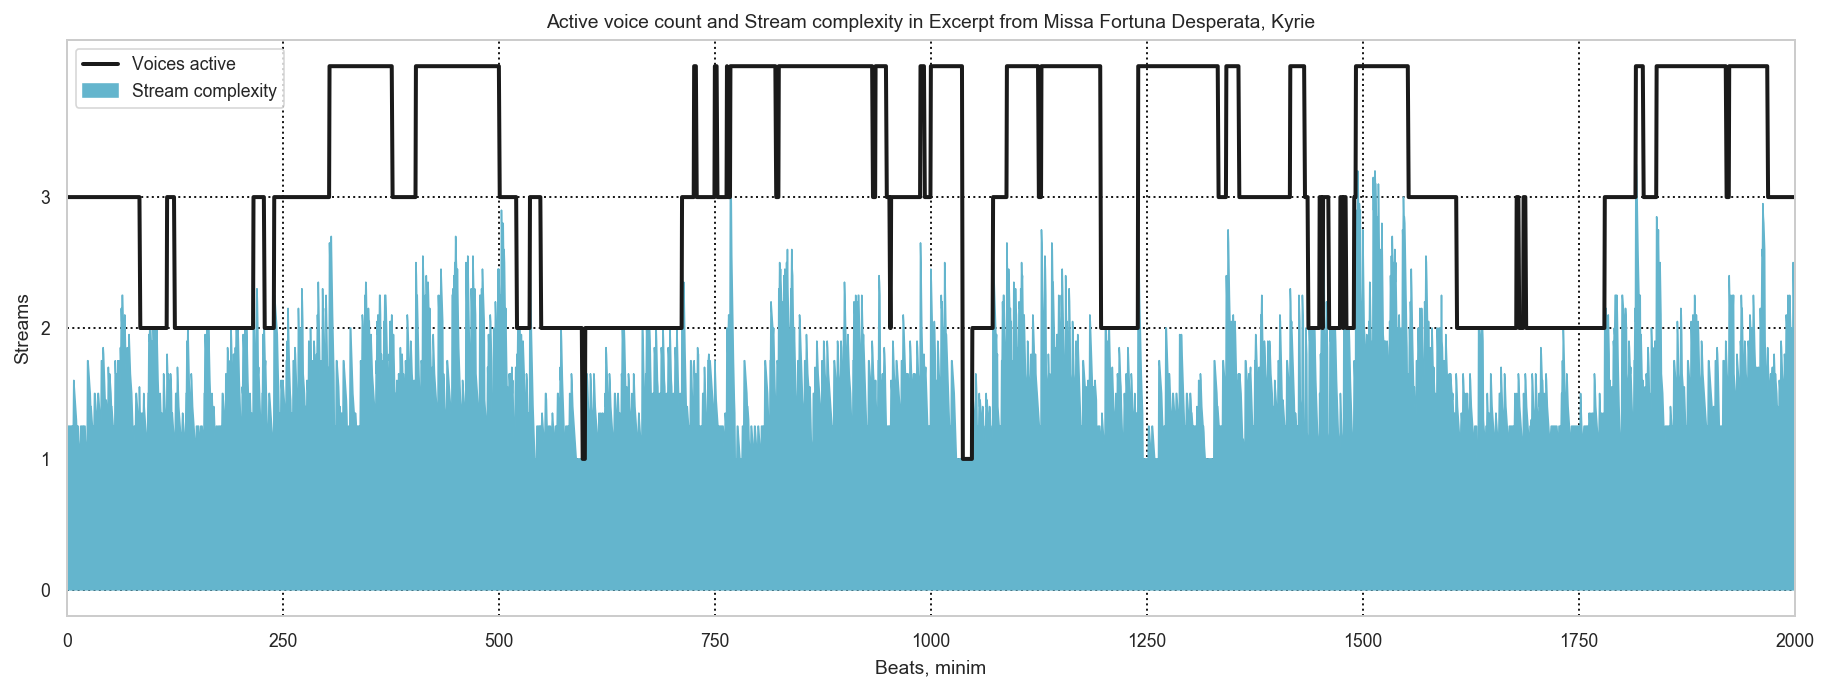

1.6070980483271375
3.45
3.142288037166086
2152.0


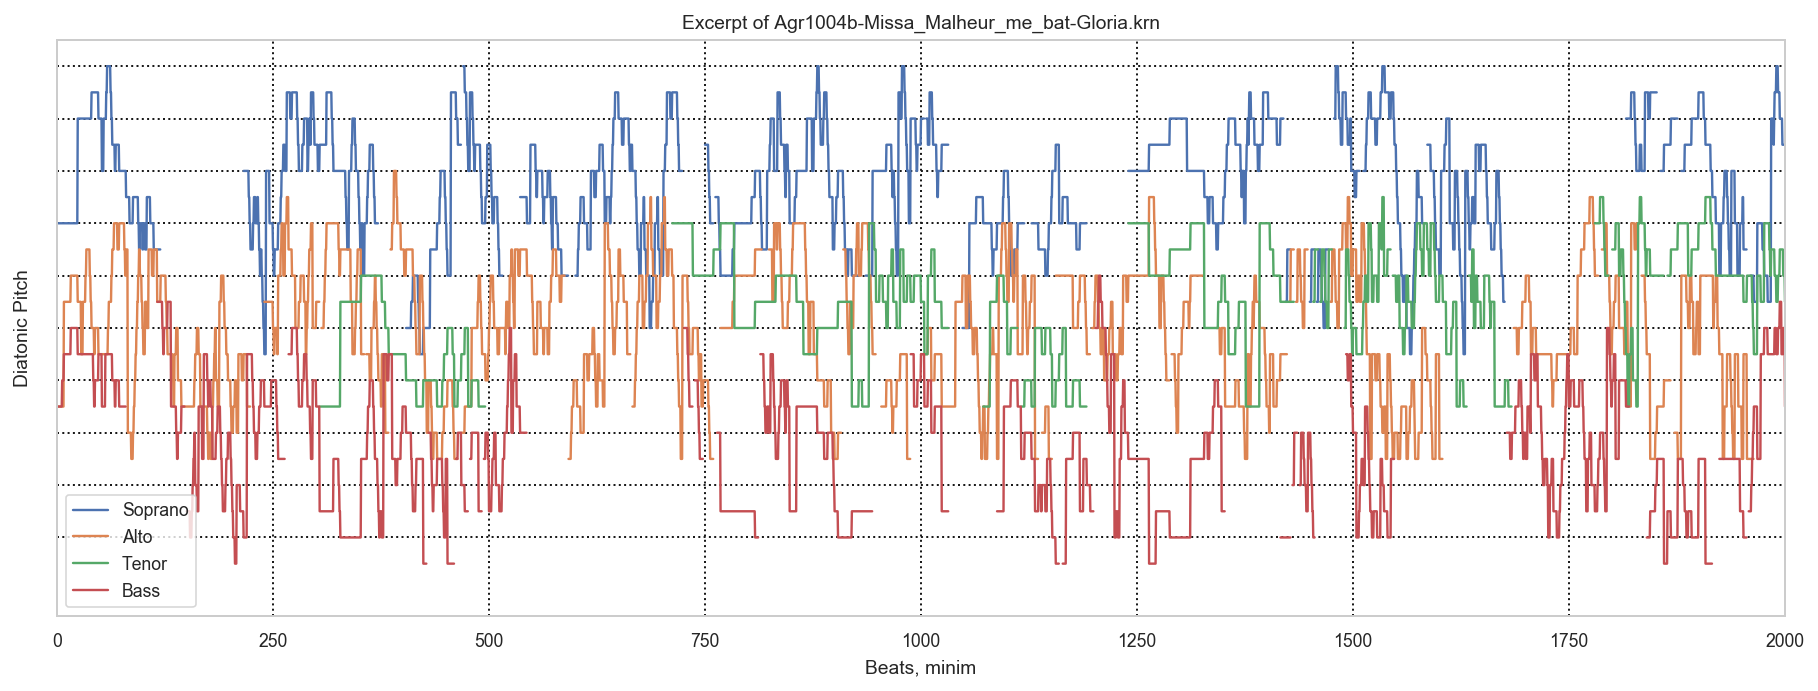

In [8]:
# test the outputs of corpus evaluation
piece = 5

df_seperated = Counterpoint_seperated[5]
A = Voices_counted[5]
dets = MusicIndex.loc[5,:]
print(dets)

os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
score = m21.converter.parse(dets.file)
df_pitchs = Score_Pitch_Steps(score)

x_r = np.array([0,2000])
os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')



fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(A,color="k",linewidth=2)
axes.fill_between(df_seperated.index,df_seperated,0,color="c")
axes.set_xbound(lower=x_r[0], upper=x_r[1])
locs, labels = plt.yticks(np.arange(0, 4, step=1))
plt.grid(color='k', linestyle=':', linewidth=1)
plt.xlabel('Beats, minim')
plt.ylabel('Streams')
axes.legend(('Voices active', 'Stream complexity'))
plt.title('Active voice count and Stream complexity in Excerpt from Missa Fortuna Desperata, Kyrie')
plt.show()

print(df_seperated.mean())
print(df_seperated.max())
print(A.mean())
print(A.index[-1])

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_pitchs)
step = np.min(np.diff(df_pitchs.index))
plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Soprano', 'Alto', 'Tenor','Bass'))
axes.yaxis.set_ticklabels([])
plt.xlabel('Beats, minim')
plt.ylabel('Diatonic Pitch')
plt.title('Excerpt of ' + dets.file)

axes.set_xbound(lower=x_r[0], upper=x_r[1])
locs, labels = plt.yticks(np.arange(25, 44, step=2))
plt.show()

# Trends on central tendencies

In [9]:
# save these results from the last above cell
os.chdir('/Users/finn/Documents/DDMAL/Scores')
f=open('Masses_Comp_Summary_Stats_Stream_3.pkl','rb')
Summary_Streaming=pickle.load(f)
f.close()

df_cycles = Summary_Streaming['Cycle_stats']
cyc_df = Summary_Streaming['Movement_stats'] 
mainCycle = ['Kyrie','Gloria', 'Credo', 'Sanctus', 'Agnus']
os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')

In [10]:
len(cyc_df)

1042

In [11]:
cyc_df.loc[1040:]

,Mass,MassID,Mvnt,Composer,CompID,C_Mean,C_Max,V_Mean,V_Max,C_R_Mean,C_R_Max,V_R_Mean,V_R_Max,file,Era,Time
1040,Missa_Vidi_Speciosam,Vic1018,Sanctus,Tomás Luis de Victoria,Vic,2.027821,4.55,4.588256,6.0,0.016435,0.0,-0.459192,-1.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...,1576-1600,5.0
1041,Missa_Vidi_Speciosam,Vic1018,Agnus,Tomás Luis de Victoria,Vic,2.226250,3.45,6.307463,7.0,0.214864,-1.1,1.260015,0.0,0 Agr1001a-Missa_In_myne_zin-Gloria.kr...,1576-1600,5.0


In [12]:
df_cycles['Composer'].value_counts()

Giovanni Pierluigi da Palestrina    101
Pierre de la Rue                     26
Unverified Josquin                   18
Tomás Luis de Victoria               17
Josquin des Prez                     12
Johannes Ockeghem                    11
Johannes Martini                      8
Marbrianus de Orto                    5
Guillaume Du Fay                      4
Anonymus                              3
Obrecht                               3
Alexander Agricola                    2
Johannes Tinctoris                    2
Antoine de Fevin                      1
Pipelare                              1
Ludwig Daser                          1
Antoine Busnoys                       1
Name: Composer, dtype: int64

In [ ]:
print(sp.stats.spearmanr(cyc_df.C_Mean,cyc_df.V_Max))
print(sp.stats.spearmanr(cyc_df.C_Mean,cyc_df.V_Mean))
print(len(cyc_df.C_Mean)-2)
cyc_df.corr(method='spearman') 
# rho(V_max,C_max)= 0.82 Very high. with C_Mean is lower 0.72. There is variance beyond the number of voices
# also zoom in to relative values within cycles and C_R_mean,V_R_mean down to 0.49

In [ ]:
print(cyc_df['V_Max'].value_counts())
#cyc_df = cyc_df[cyc_df.V_Max>2]
A_df = cyc_df[cyc_df.V_Max==5]
print(sp.stats.spearmanr(A_df.C_Mean,A_df.V_Mean))
print([A_df.V_Max.loc[71],len(A_df.C_Mean)-2])
A_df = cyc_df[cyc_df.V_Max==4]
print(sp.stats.spearmanr(A_df.C_Mean,A_df.V_Mean))
print([A_df.V_Max.loc[1],len(A_df.C_Mean)-2])
A_df.corr(method='spearman') 

In [ ]:
sns.set_context("paper")
fig= plt.figure(figsize=(6,3))
bplot=sns.set_style("whitegrid")
axes= fig.add_axes([0.2,0.22,0.6,0.6])
plt.scatter(cyc_df.C_Mean,cyc_df.V_Max)
plt.xlabel('Mean Streaming',fontsize=9)
plt.ylabel('Number of Voice Parts',fontsize=9)
plt.tick_params('x',labelsize=8)
plt.tick_params('y',labelsize=8)

plt.title('Mean Streaming vs Number of Parts per Mass Movement',fontsize=9)
# rho = 0.78
plt.savefig("Voices_vs_Streaming_scatter.png",dpi = 400)
plt.show()

In [ ]:
#boxplot on distributions by ERA

# SingleFactor on average values of summary stats on selected streaming complexity measure
# https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/
# https://cmdlinetips.com/2018/03/how-to-make-boxplots-in-python-with-pandas-and-seaborn/
# gather a random subset of movements per era overwhich to regress 
sampN = 50;
print(cyc_df['Era'].value_counts())
A = []
for i in range(7):
    if len(cyc_df.loc[cyc_df['Time'] == i])>sampN-1:
        A.append(cyc_df.loc[cyc_df['Time'] == i].sample(n=sampN))
times_df = pd.concat(A)
years = ['1450-1475', '1476-1500','1501-1525', '1526-1550', '1551-1575', '1576-1600']



left, width = 0.17, 0.18
bottom, height = 0.2, 0.7
spacing = 0.02
n = 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_context("paper")

#axes.set_title("Mean Streaming complexity and voice count per movement",fontsize=14)
sns.set(style="darkgrid")
ax = fig.add_axes(rect)
st = 'V_Mean'
sns.violinplot(y='Era', x=st,data=cyc_df,order=years,width=0.8,palette="Blues",linewidth=1)
print(sp.stats.linregress(times_df['Time'],times_df[st]))
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(times_df['Time'],times_df[st])
plt.plot(intercept + slope*times_df['Time'], times_df['Time'],'r', label='fitted line')
ax.axes.set_xbound(lower=2,upper=8)
ax.axes.set_ybound(lower=-0.5,upper=5.5)
ax.set_xticks(np.arange(2,8))
ax.set_xlabel("Voices Active",fontsize=9)
ax.tick_params(labelsize=8)
ax.set_yticklabels(years)
ax.set_title('All Movements',fontsize=9)


n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
sns.set_style("whitegrid")
bplot= fig.add_axes(rect, sharey=ax)
st = 'C_Mean'
sns.violinplot(y='Era', x=st,data=cyc_df,order=years,width=0.8,palette="Blues",linewidth=1)
print(sp.stats.linregress(times_df['Time'],times_df[st]))
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(times_df['Time'],times_df[st])
plt.plot(intercept + slope*times_df['Time'], times_df['Time'],'r', label='fitted line')
bplot.axes.set_xbound(lower=1,upper=3)
bplot.axes.set_ybound(lower=-0.5,upper=5.5)
bplot.set_xticks(np.arange(1,3.0,0.5))
bplot.set_xlabel("Mean Streaming",fontsize=9)
bplot.tick_params('x',labelsize=8)
bplot.tick_params(axis="y", labelleft=False)
bplot.set_ylabel('')
bplot.set_title('All Movements',fontsize=9)


A_df = cyc_df[cyc_df.V_Max==4]
print(A_df['Era'].value_counts())
A = []
for i in range(7):
    if len(A_df.loc[A_df['Time'] == i])>sampN:
        A.append(A_df.loc[A_df['Time'] == i].sample(n=sampN))
times_df = pd.concat(A)

n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
sns.set(style="darkgrid")
bplot= fig.add_axes(rect, sharey=ax)
st = 'V_Mean'
sns.violinplot(y='Era', x=st,data=A_df,order=years,width=0.8,palette="Blues",linewidth=1)
print(sp.stats.linregress(times_df['Time'],times_df[st]))
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(times_df['Time'],times_df[st])
plt.plot(intercept + slope*times_df['Time'], times_df['Time'],'r', label='fitted line')
bplot.axes.set_xbound(lower=2,upper=8)
bplot.axes.set_ybound(lower=-0.5,upper=5.5)
bplot.set_xticks(np.arange(2,8))
bplot.set_xlabel("Voices Active",fontsize=9)
bplot.tick_params('x',labelsize=8)
bplot.tick_params(axis="y", labelleft=False)
bplot.set_ylabel('')
bplot.set_title('Four Voice Parts',fontsize=9)

n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
sns.set_style("whitegrid")
bplot= fig.add_axes(rect, sharey=ax)
st = 'C_Mean'
sns.violinplot(y='Era', x=st,data=A_df,order=years,width=0.8,palette="Blues",linewidth=1)
print(sp.stats.linregress(times_df['Time'],times_df[st]))
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(times_df['Time'],times_df[st])
plt.plot(intercept + slope*times_df['Time'], times_df['Time'],'r', label='fitted line')

bplot.axes.set_xbound(lower=1,upper=3)
bplot.axes.set_ybound(lower=-0.5,upper=5.5)
bplot.set_xticks(np.arange(1,3.5,0.5))
bplot.set_xlabel("Mean Streaming",fontsize=9)
bplot.tick_params('x',labelsize=8)
bplot.tick_params(axis="y", labelleft=False)
bplot.set_ylabel('')
bplot.set_title('Four Voice Parts',fontsize=9)

plt.savefig("Era_trends.png",dpi = 300)

In [ ]:

# median performance of regression 
st = 'V_Mean'
k = []
kp = []
f = []
fp = []
for i in range (100):
    A = []
    B = []
    for i in range(6):
        if len(cyc_df.loc[cyc_df['Time'] == i])>sampN:
            A.append(cyc_df.loc[cyc_df['Time'] == i].sample(n=sampN))
            B.append(A[-1][st])
    times_df = pd.concat(A)
    a = sp.stats.linregress(times_df['Time'],times_df[st])
    k.append(a.rvalue**2)
    kp.append(a.pvalue)
    b = sp.stats.f_oneway(B[0],B[1],B[2],B[3],B[4]) # https://www.pythonfordatascience.org/anova-python/
    f.append(b.statistic)
    fp.append(b.pvalue)
print(st)
print(np.median(k))
print(np.median(kp))
print(np.median(f))
print(np.median(fp))

st = 'C_Mean'
k = []
kp = []
f = []
fp = []
for i in range (100):
    A = []
    B = []
    for i in range(6):
        if len(cyc_df.loc[cyc_df['Time'] == i])>sampN:
            A.append(cyc_df.loc[cyc_df['Time'] == i].sample(n=sampN))
            B.append(A[-1][st])
    times_df = pd.concat(A)
    a = sp.stats.linregress(times_df['Time'],times_df[st])
    k.append(a.rvalue**2)
    kp.append(a.pvalue)
    b = sp.stats.f_oneway(B[0],B[1],B[2],B[3],B[4]) # https://www.pythonfordatascience.org/anova-python/
    f.append(b.statistic)
    fp.append(b.pvalue)
print(st)
print(np.median(k))
print(np.median(kp))
print(np.median(f))
print(np.median(fp))

sampN = 45

A_df = cyc_df[cyc_df.V_Max==4]
st = 'V_Mean'
k = []
kp = []
f = []
fp = []
for i in range (100):
    A = []
    B = []
    for i in range(6):
        if len(A_df.loc[A_df['Time'] == i])>sampN:
            A.append(A_df.loc[A_df['Time'] == i].sample(n=sampN))
            B.append(A[-1][st])
    times_df = pd.concat(A)
    a = sp.stats.linregress(times_df['Time'],times_df[st])
    k.append(a.rvalue**2)
    kp.append(a.pvalue)
    b = sp.stats.f_oneway(B[0],B[1],B[2],B[3],B[4]) # https://www.pythonfordatascience.org/anova-python/
    f.append(b.statistic)
    fp.append(b.pvalue)
print(st)
print(np.median(k))
print(np.median(kp))
print(np.median(f))
print(np.median(fp))

st = 'C_Mean'
k = []
kp = []
f = []
fp = []
for i in range (100):
    A = []
    B = []
    for i in range(6):
        if len(A_df.loc[A_df['Time'] == i])>sampN:
            A.append(A_df.loc[A_df['Time'] == i].sample(n=sampN))
            B.append(A[-1][st])
    times_df = pd.concat(A)
    a = sp.stats.linregress(times_df['Time'],times_df[st])
    k.append(a.rvalue**2)
    kp.append(a.pvalue)
    b = sp.stats.f_oneway(B[0],B[1],B[2],B[3],B[4]) # https://www.pythonfordatascience.org/anova-python/
    f.append(b.statistic)
    fp.append(b.pvalue)
print(st)
print(np.median(k))
print(np.median(kp))
print(np.median(f))
print(np.median(fp))


In [ ]:
sns.set_context("paper")
#boxplot on distributions by composer, ordered roughly chronologically
years = cyc_df.Era.unique()

sns.set_style("whitegrid")
fig= plt.figure(figsize=(6,2))
bplot= fig.add_axes([0.1,0.4,0.8,0.5])
composers_ordered=['Guillaume Du Fay','Johannes Ockeghem','Antoine Busnoys',
                   'Johannes Martini','Johannes Tinctoris','Alexander Agricola',
                   'Pipelare','Obrecht','Marbrianus de Orto','Antoine de Fevin',
                   'Josquin des Prez','Pierre de la Rue','Ludwig Daser',
                  'Giovanni Pierluigi da Palestrina','Tomás Luis de Victoria']
st = 'C_Mean'
sns.violinplot(x='Composer', y=st,data=cyc_df,order=composers_ordered
                       ,width=1,palette="colorblind",linewidth=1)

bplot.axes.set_ybound(lower=1,upper=3.0)

#bplot.set_xlabel("Era",fontsize=14)
bplot.set_ylabel("Mean Streaming",fontsize=9)
bplot.set_xticklabels(['Du Fay', 'Ockeghem','Busnoy', 
       'Martini','Tinctoris','Agricola','Pipelare', 'Obrecht','Orto',
       'Fevin','Josquin','La Rue','Daser','Palestrina','Victoria'])
bplot.tick_params('x',labelsize=8,labelrotation = 45)
bplot.tick_params('y',labelsize=8)
bplot.axes.set_title("Mean Streaming Distribution across Movements per Composer",fontsize=9)

plt.savefig("Composer_trends_SC.png",dpi = 300)

In [ ]:
# relative voice count and complexity of mass movements

left, width = 0.14, 0.35
bottom, height = 0.18, 0.72
spacing = 0.02

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_context("paper")
sns.set_style("whitegrid")
n = 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax1 = fig.add_axes(rect)


st = 'C_R_Mean'   
aov = pg.mixed_anova(data=cyc_df, dv=st, within='Mvnt', subject='Mass', between = 'Composer', correction = True)
print(aov)
sns.violinplot(x='Mvnt', y=st,data=cyc_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax1.axes.set_xlabel("Relative Mean Streaming",fontsize=9)
ax1.axes.set_ybound(lower=-0.5,upper=0.5)
ax1.set_ylabel("Relative Mean Streaming",fontsize=9)
ax1.set_title("Mean Streaming Cycle Trends",fontsize=9)
ax1.set_xlabel("Mass Movements",fontsize=9)
ax1.tick_params(labelsize=8)

sns.set_style("darkgrid")
n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax2 = fig.add_axes(rect)


st = 'V_R_Mean'
aov = pg.mixed_anova(data=cyc_df, dv=st, within='Mvnt', subject='Mass', between = 'Composer', correction = True)
print(aov)
sns.violinplot(x='Mvnt', y=st,data=cyc_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax2.axes.set_ybound(lower=-1.5,upper=1.5)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Mass Movements",fontsize=9)
ax2.set_ylabel("Relative Voices Active",fontsize=9)
ax2.set_title("Voices Active Cycle Trends",fontsize=9)
ax2.tick_params(labelsize=8)

plt.savefig("Movements_Relative_Counts.png",dpi = 400)

In [ ]:
# relative voice count and complexity of mass movements
sns.set_context("paper")
st = 'C_R_Mean'
Wanted_Comp = 'Unverified Josquin' #'Giovanni Pierluigi da Palestrina'#,'Tomás Luis de Victoria','Pierre de la Rue','Josquin des Prez','Unverified Josquin','Johannes Ockeghem']
shortName='Josquin (Weak Attribution)'
# Wanted_Comp = 'Giovanni Pierluigi da Palestrina'
# shortName = 'Palestrina'
# Wanted_Comp = 'Josquin des Prez' #'Giovanni Pierluigi da Palestrina'#,'Tomás Luis de Victoria','Pierre de la Rue','Josquin des Prez','Unverified Josquin','Johannes Ockeghem']
# shortName='Josquin (Strong Attribution)'

Names = Wanted_Comp.split(' ')
Sub_df = cyc_df[cyc_df.Composer==Wanted_Comp]
print(len(Sub_df))

left, width = 0.14, 0.35
bottom, height = 0.18, 0.72
spacing = 0.02

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_context("paper")
sns.set_style("whitegrid")
n = 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax1 = fig.add_axes(rect)

st = 'C_R_Mean'   
#https://pingouin-stats.org/generated/pingouin.pairwise_gameshowell.html#pingouin.pairwise_gameshowell
a = pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt') 
print(a)
sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax1.axes.set_xlabel("Relative Mean Streaming",fontsize=9)
ax1.axes.set_ybound(lower=-0.5,upper=0.5)
ax1.set_ylabel("Relative Mean Streaming",fontsize=9)
ax1.set_title("Mean Streaming Cycle Trends",fontsize=9)
ax1.set_xlabel("Movements by " + shortName,fontsize=8)
ax1.tick_params(labelsize=8)

sns.set_style("darkgrid")
n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax2 = fig.add_axes(rect)

st = 'V_R_Mean'
#https://pingouin-stats.org/generated/pingouin.pairwise_gameshowell.html#pingouin.pairwise_gameshowell
a = pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt') 
print(a)
sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax2.axes.set_ybound(lower=-1.5,upper=1.5)
ax2.tick_params(labelsize=8)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Movements by " + shortName,fontsize=8)
ax2.set_ylabel("Relative Voices Active",fontsize=9)
ax2.set_title("Voices Active Cycle Trends",fontsize=9)
ax2.tick_params(labelsize=8)

plt.savefig(shortName +"Movements_Relative_Counts.png",dpi = 400)



In [ ]:

#https://pingouin-stats.org/generated/pingouin.pairwise_gameshowell.html#pingouin.pairwise_gameshowell
st = 'V_R_Mean'
pg.pairwise_gameshowell(data=cyc_df, dv=st,between='Mvnt')  
# https://pingouin-stats.org/generated/pingouin.pairwise_tukey.html#pingouin.pairwise_tukey
#pg.pairwise_tukey(data=cyc_df, dv=st,between='Mvnt') 

In [ ]:
#https://pingouin-stats.org/generated/pingouin.pairwise_gameshowell.html#pingouin.pairwise_gameshowell
st = 'C_R_Mean'
pg.pairwise_gameshowell(data=cyc_df, dv=st,between='Mvnt')  
# https://pingouin-stats.org/generated/pingouin.pairwise_tukey.html#pingouin.pairwise_tukey
#pg.pairwise_tukey(data=cyc_df, dv=st,between='Mvnt') 

In [ ]:
#comparing Josquin des Prex and Unverified Josquin
# result: significant interaction of composer and 
# masse movemens for Streaming complexity (p-unc=0.007461)
# and no interaction in Voices Active (p-unc = 0.193)
JOS = ['Josquin des Prez','Unverified Josquin']
Sub_df = cyc_df[cyc_df.Composer.isin(JOS)]

st = 'C_R_Mean'   
aov = pg.mixed_anova(data=Sub_df, dv=st, within='Mvnt', subject='Mass', between = 'Composer', correction = True)
print(aov)

st = 'V_R_Mean'
aov = pg.mixed_anova(data=Sub_df, dv=st, within='Mvnt', subject='Mass', between = 'Composer', correction = True)
print(aov)


SOURCES

https://pingouin-stats.org/generated/pingouin.anova.html
https://fr.slideshare.net/plummer48/reporting-a-factorial-anova

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
https://seaborn.pydata.org/tutorial/regression.html#regression-tutorial
https://seaborn.pydata.org/generated/seaborn.regplot.html#seaborn.regplot
https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter
https://matplotlib.org/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py



In [ ]:
# Palestrina effect? 
# Composers 
# exclude Palistrina because so so many 
sns.set_context("paper")
st = 'C_R_Mean'
Wanted_Comp = 'Giovanni Pierluigi da Palestrina'#,'Tomás Luis de Victoria','Pierre de la Rue','Josquin des Prez','Unverified Josquin','Johannes Ockeghem']
sns.set_style("whitegrid")
Names = Wanted_Comp.split(' ')
Sub_df = cyc_df[cyc_df.Composer==Wanted_Comp]
print(len(Sub_df))
pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt')  

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))


plt.subplot(1,2,1)
st = 'C_R_Mean'    
ax1 = sns.violinplot(x='Mvnt', y=st,data=Sub_df, width=1,palette="colorblind", order = mainCycle)
ax1.axes.set_xlabel("Relative Mean Streaming",fontsize=11)
ax1.axes.set_ybound(lower=-0.5,upper=0.5)
ax1.set_ylabel("Relative Streaming",fontsize=11)
ax1.set_title("Palestrina Cycle Trends",fontsize=12)
ax1.set_xlabel("Cycle Movements",fontsize=11)
ax1.tick_params(labelsize=11)

Sub_df = cyc_df[cyc_df.Composer!=Wanted_Comp]
pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt')  

plt.subplot(1,2,2)
ax2 = sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax2.axes.set_ybound(lower=-0.5,upper=0.5)
ax2.set_xlabel("Cycle Movements",fontsize=11)
ax2.set_ylabel('')
ax2.set_title("Other Masses Cycle Trends",fontsize=12)
ax2.tick_params(labelsize=11)
ax2.set_yticklabels([])

plt.savefig("Palestrina_Movements_SC.png",dpi = 400,bbox_inches = "tight")
plt.show()

In [ ]:
# Palestrina effect? 
# Composers 
# exclude Palistrina because so so many 
sns.set_context("paper")
st = 'V_R_Mean'
Wanted_Comp = 'Giovanni Pierluigi da Palestrina'#,'Tomás Luis de Victoria','Pierre de la Rue','Josquin des Prez','Unverified Josquin','Johannes Ockeghem']
sns.set_style("darkgrid")
Names = Wanted_Comp.split(' ')
Sub_df = cyc_df[cyc_df.Composer==Wanted_Comp]
print(len(Sub_df))
pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt')  

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

plt.subplot(1,2,1)
st = 'V_R_Mean'    
ax1 = sns.violinplot(x='Mvnt', y=st,data=Sub_df, width=1,palette="colorblind", order = mainCycle)
ax1.axes.set_ybound(lower=-1,upper=1)
ax1.axes.set_ylabel("Relative Voice Counts",fontsize=11)
ax1.set_title("Palestrina Cycle Trends",fontsize=12)
ax1.set_xlabel("Cycle Movements",fontsize=11)
ax1.tick_params(labelsize=11)

Sub_df = cyc_df[cyc_df.Composer!=Wanted_Comp]
pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt')  

plt.subplot(1,2,2)
ax2 = sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax2.axes.set_ybound(lower=-1,upper=1)
ax2.set_xlabel("Cycle Movements",fontsize=11)
ax2.set_ylabel('')
ax2.set_title("Other Masses Cycle Trends",fontsize=12)
ax2.tick_params(labelsize=11)
ax2.set_yticklabels([])

plt.savefig("Palestrina_Movements_VC.png",dpi = 400,bbox_inches = "tight")
plt.show()

In [ ]:
# Palestrina effect? 
# Composers 
# exclude Palistrina because so so many 
sns.set_context("paper")
st = 'C_R_Mean'
Wanted_Composers = ['Giovanni Pierluigi da Palestrina','Tomás Luis de Victoria','Pierre de la Rue','Josquin des Prez','Unverified Josquin','Johannes Ockeghem']
for i in range(len(Wanted_Composers )):
    Names = Wanted_Composers[i].split(' ')
    Wanted_Comp = [Wanted_Composers[i]]
    Sub_df = cyc_df[cyc_df.Composer.isin(Wanted_Comp)]
    print(len(Sub_df))

    Sub_df = Sub_df.reset_index(drop = True)

    f, axes = plt.subplots(2,1, sharey=True, figsize=(6, 8))
    bplot = sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                     width=1,palette="colorblind", order = mainCycle,ax = axes[0])
#     bplot=sns.stripplot(x='Mvnt', y=st,data=Sub_df, 
#                        jitter=True, marker='o',alpha=0.75,
#                        color='black', order = mainCycle,ax = axes[0])

    bplot.axes.set_title("Relative complexity, " +  Wanted_Composers[i],fontsize=16)
    bplot.axes.set_ybound(lower=-0.4,upper=0.6)
    bplot.set_xlabel(" ",fontsize=14)
    bplot.set_ylabel(st ,fontsize=14)
    bplot.tick_params(labelsize=10)
    bplot=sns.set_style("whitegrid")

    Sub_df = cyc_df[~cyc_df.Composer.isin(Wanted_Comp)]
    print(len(Sub_df))

    Sub_df = Sub_df.reset_index(drop = True)

    bplot = sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                     width=1,palette="colorblind", order = mainCycle,ax = axes[1])
#     bplot=sns.stripplot(x='Mvnt', y=st,data=Sub_df, 
#                        jitter=True, marker='o',alpha=0.75,
#                        color='black', order = mainCycle,ax = axes[1])

    bplot.axes.set_title("Relative complexity, without " +  Wanted_Composers[i],fontsize=16)
    bplot.axes.set_ybound(lower=-0.4,upper=0.6)
    bplot.set_xlabel("Cycle Movements",fontsize=14)
    bplot.set_ylabel(st ,fontsize=14)
    bplot.tick_params(labelsize=10)
    bplot=sns.set_style("whitegrid")
                     
   # plt.savefig(st + "_wo_" + Names[-1] + ".png",dpi = 200,bbox_inches = "tight")

# Individual masses

In [ ]:
# retreive the last round of evaluations

os.chdir('/Users/finn/Documents/DDMAL/Scores')
f=open('Masses_CompSeries_Stream3_3.pkl','rb')
S_Complexities=pickle.load(f)
f.close()

MusicIndex = S_Complexities['MusicIndex']
Counterpoint_seperated = S_Complexities['Streaming_Complexity']
Voices_counted = S_Complexities['Voice_Counts']

os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
print(len(MusicIndex))
print(len(Counterpoint_seperated))
print(len(Voices_counted))

In [ ]:
os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')

In [ ]:
# fd carries over values from previous analysis, including metadata on each movement.
df=pd.DataFrame(columns=['Mass','MassID','Mvnt','Composer','CompID','C_Mean','C_Max','file']) #,'V_Median','V_Max'])

# choose form of complexity summary series to evaluate
Comp_Type = 'Counterpoint Complexity'
SC=Counterpoint_seperated

# fd carries over values from previous analysis, including metadata on each movement.
central_Stat = []
max_Stat = []
for i in range(len(SC)):
    df_seperated = SC[i]
    central_Stat=np.nanmean(df_seperated)
    max_Stat=np.nanmax(df_seperated)
    df = df.append({'Mass':MusicIndex.Mass[i],'MassID':MusicIndex.MassID[i],
                    'Mvnt':MusicIndex.Mvnt[i],'Composer':MusicIndex.Composer[i],
                    'CompID':MusicIndex.CompID[i], 'C_Mean':central_Stat,'C_Max':max_Stat,'file':MusicIndex.file},ignore_index=True)


# choose form of complexity summary series to evaluate

Comp_Type = 'Voice Counts'
VC=Voices_counted

# fd carries over values from previous analysis, including metadata on each movement.
central_Stat = []
max_Stat = []

for i in range(len(VC)):
    df_seperated = VC[i]
    central_Stat.append(np.nanmean(df_seperated))
    max_Stat.append(np.nanmax(df_seperated))
len(central_Stat)
# add to df
df.insert(7, "V_Mean", central_Stat, True)
df.insert(8, "V_Max", max_Stat, True)


In [ ]:
# reduce collection to relevant factors
# https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/

# Restrict Cycle movements 
print(len(df))
mainCycle = ['Kyrie','Gloria', 'Credo', 'Sanctus', 'Agnus']
cyc_df = df[df.Mvnt.isin(mainCycle)]
print(len(cyc_df))

# drop those few with insufficient voices to be worth calculating around
cyc_df = cyc_df[cyc_df.V_Max>2] 
print(len(cyc_df))


cyc_df['Composer'].value_counts()

In [ ]:
print(len(cyc_df))
cyc_df.loc[1040:]

In [ ]:
mi = 'Pal1048'
ma = "Missa Iste confessor"
Sub_df = cyc_df[cyc_df.MassID==mi]
sI = list(Sub_df.index)
sI

In [ ]:
Sub_df


In [ ]:
sI

In [ ]:
# mi = 'Pal1024'
# ma = "Missa " + "Iste confessor"
Sub_df = cyc_df[cyc_df.MassID==mi]
sI = list(Sub_df.index)
df_A = pd.DataFrame(dict(x = [],g = []))
df_C = pd.DataFrame(dict(x = [],g = []))
mmm = ['Kyrie','Gloria','Credo','Sanctus','Agnus']
n_move = {'Kyrie':0,'Gloria':1,'Credo':2,'Sanctus':3,'Agnus':4}

m_A = [0,0,0,0,0]
m_C = [0,0,0,0,0]
for i in sI:
    mv = Sub_df.loc[i,'Mvnt']
    print(mv)
    mv_n = n_move[mv]
    df = pd.DataFrame(dict(x=Voices_counted[i], g=mv_n))
    m_A[mv_n] = df.x.mean()
    print(m_A)
    df_A = df_A.append(df, ignore_index=True)
    df = pd.DataFrame(dict(x=Counterpoint_seperated[i], g=mv_n))
    df_C = df_C.append(df, ignore_index=True)
    m_C[mv_n] = df.x.mean()
df_A = df_A.sort_values(by='g')
df_C = df_C.sort_values(by='g')


left, width = 0.14, 0.35
bottom, height = 0.18, 0.72
spacing = 0.02

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_context("paper")
sns.set_style("whitegrid")
n = 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax1 = fig.add_axes(rect)

sns.violinplot(x='g', y='x',data=df_C, width=1,palette="pastel",bw=.1,inner='quartile')
for i in range(len(m_C)):
    ax1.plot([i],m_C[i],color ='black', marker="D", markersize=5)
ax1.set_xticks([0,1,2,3,4])
ax1.set_xticklabels(mmm)
ax1.axes.set_xlabel("Relative Mean Streaming",fontsize=9)
ax1.set_ylabel("Streaming Complexity values",fontsize=9)
ax1.set_title(ma + " Streaming Complexity",fontsize=9)
ax1.set_xlabel("Movement",fontsize=9)
ax1.tick_params(labelsize=8)


sns.set_style("darkgrid")
n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax2 = fig.add_axes(rect)

st = 'V_R_Mean'
i=1
sns.violinplot(x='g', y='x',data=df_A, width=1,palette="pastel",bw=.1,inner='quartile')
for i in range(len(m_C)):
    ax2.plot([i],m_A[i],color ='black', marker="D", markersize=5)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Movement",fontsize=9)

ax2.set_ylabel("Voices Active values",fontsize=9)
ax2.set_title(ma + " Voices Active",fontsize=9)
ax2.tick_params(labelsize=8)
ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(mmm)

plt.savefig(mi +"_mvmt_dist.png",dpi = 400)



In [ ]:
mi = 'Jos1202'
ma = "Missa Sine nomine"
Sub_df = cyc_df[cyc_df.MassID==mi]
sI = list(Sub_df.index)
df_A = pd.DataFrame(dict(x = [],g = []))
df_C = pd.DataFrame(dict(x = [],g = []))
mmm = ['Kyrie','Gloria','Credo','Sanctus','Agnus']
n_move = {'Kyrie':0,'Gloria':1,'Credo':2,'Sanctus':3,'Agnus':4}

m_A = [0,0,0,0,0]
m_C = [0,0,0,0,0]
for i in sI:
    mv = Sub_df.loc[i,'Mvnt']
    print(mv)
    mv_n = n_move[mv]
    df = pd.DataFrame(dict(x=Voices_counted[i], g=mv_n))
    m_A[mv_n] = df.x.mean()
    print(m_A)
    df_A = df_A.append(df, ignore_index=True)
    df = pd.DataFrame(dict(x=Counterpoint_seperated[i], g=mv_n))
    df_C = df_C.append(df, ignore_index=True)
    m_C[mv_n] = df.x.mean()
df_A = df_A.sort_values(by='g')
df_C = df_C.sort_values(by='g')


left, width = 0.14, 0.35
bottom, height = 0.18, 0.72
spacing = 0.02

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_context("paper")
sns.set_style("whitegrid")
n = 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax1 = fig.add_axes(rect)

sns.violinplot(x='g', y='x',data=df_C, width=1,palette="pastel",bw=.1,inner='quartile')
for i in range(len(m_C)):
    ax1.plot([i],m_C[i],color ='black', marker="D", markersize=5)
ax1.set_xticks([0,1,2,3,4])
ax1.set_xticklabels(mmm)
ax1.axes.set_xlabel("Relative Mean Streaming",fontsize=9)
ax1.set_ylabel("Streaming Complexity values",fontsize=9)
ax1.set_title(ma + " Streaming Complexity",fontsize=9)
ax1.set_xlabel("Movement",fontsize=8)
ax1.tick_params(labelsize=8)

sns.set_style("darkgrid")
n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax2 = fig.add_axes(rect)


st = 'V_R_Mean'
i=1
ax2 = sns.violinplot(x='g', y='x',data=df_A, width=1,palette="pastel",bw=.1,inner='quartile')
for i in range(len(m_C)):
    ax2.plot([i],m_A[i],color ='black', marker="D", markersize=5)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Movement",fontsize=9)

ax2.set_ylabel("Voices Active values",fontsize=9)
ax2.set_title(ma + " Voices Active",fontsize=9)
ax2.tick_params(labelsize=8)
ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(mmm)

plt.savefig(mi +"_mvmt_dist.png",dpi = 400)



# Old plots

In [ ]:
df_pitchs = Score_Pitch_Steps(score)
x_r = np.array([180,299])

fig= plt.figure(figsize=(10,4))
axes= fig.add_axes([0.1,0.2,0.8,0.7])
clabels = df_pitchs.columns
for i in range(len(clabels)):    
    axes.plot(df_pitchs[clabels[i]]+-.1*i)
step = np.min(np.diff(df_pitchs.index))
plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius', 'Altus', 'Tenor','Bassus'))
axes.set_yticks([])
axes.xaxis.set_ticks(np.arange(180,298,8))
axes.xaxis.set_ticklabels(np.arange(1,16))
plt.xlabel('Measures (excerpt)')
plt.ylabel('Diatonic Pitch')
plt.title('Excerpt of Kyrie from Josquin''s Missa Fortuna Desperata')

axes.set_xbound(lower=x_r[0], upper=x_r[1])
#plt.savefig("pitch_1.png")
plt.show()


fig= plt.figure(figsize=(10,4))
axes= fig.add_axes([0.1,0.2,0.8,0.7])
#df_seperated = Entry_Cues(score)
df_cues = 0.5*Entry_Cues(score)
df_seperated = Cue_Reduction(df_cues)
axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.fill_between(df_cues.index,df_cues['Voice_1']+3,3,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_2']+2,2,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_3']+1,1,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_4'],0,color='gainsboro')
axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.set_yticks([])
axes.xaxis.set_ticks(np.arange(180,298,8))
axes.xaxis.set_ticklabels(np.arange(1,16))
plt.xlabel('Measures (excerpt)')
plt.ylabel('Entry Cues')
plt.title('Seperation cues per line in Excerpt from Missa Fortuna Desperata, Kyrie')

plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius cues', 'Altus cues', 'Tenor cues','Bassus cues','Shared cues'),loc=3)
#plt.savefig("cues_1.png")
plt.show()


fig= plt.figure(figsize=(10,4))
axes= fig.add_axes([0.1,0.2,0.8,0.7])
df_cues = 0.5*Onset_Cues(score)
df_seperated = Cue_Reduction(df_cues)
axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.fill_between(df_cues.index,df_cues['Voice_1']+3,3,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_2']+2,2,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_3']+1,1,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_4'],0,color='gainsboro')
axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.xaxis.set_ticks(np.arange(180,298,8))
axes.xaxis.set_ticklabels(np.arange(1,16))
axes.set_yticks([])
plt.xlabel('Measures (excerpt)')
plt.ylabel('Onsets Cues')
plt.title('Seperation cues per line in Excerpt from Missa Fortuna Desperata, Kyrie')
plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius cues', 'Altus cues', 'Tenor cues','Bassus cues','Shared cues'),loc=3)
plt.show()

fig= plt.figure(figsize=(10,4))
axes= fig.add_axes([0.1,0.2,0.8,0.7])
#df_seperated  = 0.5*Motion_Cues(score)
df_cues = 0.5*Motion_Cues(score) 
df_seperated = Cue_Reduction(df_cues)
axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.fill_between(df_cues.index,df_cues['Voice_1']+3,3,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_2']+2,2,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_3']+1,1,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_4'],0,color='gainsboro')
axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.xaxis.set_ticks(np.arange(180,298,8))
axes.xaxis.set_ticklabels(np.arange(1,16))
axes.set_yticks([])
plt.xlabel('Measures (excerpt)')
plt.ylabel('Pitch change')
plt.title('Seperation cues per line in Excerpt from Missa Fortuna Desperata, Kyrie')
plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius cues', 'Altus cues', 'Tenor cues','Bassus cues','Shared cues'),loc=3)
plt.show()



df_cE = Entry_Cues(score)
df_sE = Cue_Reduction(df_cE)

df_cO = Onset_Cues(score)
df_sO= Cue_Reduction(df_cO)

df_cM = Motion_Cues(score) 
df_sM = Cue_Reduction(df_cM)

df_cO = df_cO.mask(df_cM.abs()>0,0)
df_c = 0.5*df_cO + 0.5*df_cM.abs() + df_cE
df_c = df_c.mask(df_c>1,1)
df_cues = Comp_Decay(df_c.abs(),0.2)
df_cues = df_cues.mask(df_cues>1,1)

df_sO = df_sO.mask(df_sM.abs()>0,0)
df_s = 0.5*df_sO + 0.5*df_sM.abs() + df_sE
df_s = df_s.mask(df_s>1,1)
df_seperated = Comp_Decay(df_s.abs(),0.2)
df_seperated = df_seperated.mask(df_seperated>1,1)

fig= plt.figure(figsize=(10,4))
axes= fig.add_axes([0.1,0.2,0.8,0.7])
#df_seperated  = 0.5*Motion_Cues(score)

axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.fill_between(df_cues.index,df_cues['Voice_1']+3,3,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_2']+2,2,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_3']+1,1,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_4'],0,color='gainsboro')
axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.xaxis.set_ticks(np.arange(180,298,8))
axes.xaxis.set_ticklabels(np.arange(1,16))
axes.set_yticks([])
plt.xlabel('Measures (excerpt)')
plt.ylabel('Seperation Cues per Voice')
plt.title('Seperation cues per line in Excerpt from Missa Fortuna Desperata, Kyrie')
plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius cues', 'Altus cues', 'Tenor cues','Bassus cues','Shared cues'),loc=3)
#plt.savefig("cues_1.png")
plt.show()

fig= plt.figure(figsize=(10,4))
axes= fig.add_axes([0.1,0.2,0.8,0.7])
A =  Voice_Count(score)
df_seperated = Stream_Complexity_Smoothed(score)

axes.plot(A,color='darkred',linewidth=2)
axes.plot(df_seperated.index,df_seperated['Total'],0,color="darkcyan")

df_seperated = Streaming(score)
axes.plot(df_seperated.index,df_seperated['Total'],0,color="cyan")

axes.legend(('Voices Active', 'Streaming Complexity','Streaming'))
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.xaxis.set_ticks(np.arange(180,298,8))
axes.xaxis.set_ticklabels(np.arange(1,16))
axes.set_yticks([])
plt.xlabel('Beats, minim')
plt.ylabel('Streams')
plt.title(f)
#plt.savefig("Streams_dist1.png")
plt.show()


In [ ]:
df_pitchs = Score_Pitch_Steps(score)
x_r = np.array([180,299])

fig= plt.figure(figsize=(10,4))
axes= fig.add_axes([0.1,0.2,0.8,0.7])
clabels = df_pitchs.columns
for i in range(len(clabels)):    
    axes.plot(df_pitchs[clabels[i]]+-.1*i)
step = np.min(np.diff(df_pitchs.index))
plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius', 'Altus', 'Tenor','Bassus'))
axes.set_yticks([])
axes.xaxis.set_ticks(np.arange(180,298,8))
axes.xaxis.set_ticklabels(np.arange(1,16))
plt.xlabel('Measures (excerpt)')
plt.ylabel('Diatonic Pitch')
plt.title('Excerpt of Kyrie from Josquin''s Missa Fortuna Desperata')

axes.set_xbound(lower=x_r[0], upper=x_r[1])
#plt.savefig("pitch_1.png")
plt.show()

df_cE = Entry_Cues(score)
df_sE = Cue_Reduction(df_cE)

df_cO = Onset_Cues(score)
df_sO= Cue_Reduction(df_cO)

df_cM = Motion_Cues(score) 
df_sM = Cue_Reduction(df_cM)

df_cO = df_cO.mask(df_cM.abs()>0,0)
df_c = 0.25*df_cO + 0.5*df_cM.abs() + df_cE
df_c = df_c.mask(df_c>1,1)
df_cues = Comp_Decay(df_c.abs(),0.2)
df_cues = df_cues.mask(df_cues>1,1)

df_sO = df_sO.mask(df_sM.abs()>0,0)
df_s = 0.5*df_sO + 0.5*df_sM.abs() + df_sE
df_s = df_s.mask(df_s>1,1)
df_seperated = Comp_Decay(df_s.abs(),0.2)
df_seperated = df_seperated.mask(df_seperated>1,1)

fig= plt.figure(figsize=(10,4))
axes= fig.add_axes([0.1,0.2,0.8,0.7])
#df_seperated  = 0.5*Motion_Cues(score)

axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.fill_between(df_cues.index,df_cues['Voice_1']+3,3,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_2']+2,2,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_3']+1,1,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_4'],0,color='gainsboro')
axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.xaxis.set_ticks(np.arange(180,298,8))
axes.xaxis.set_ticklabels(np.arange(1,16))
axes.set_yticks([])
plt.xlabel('Measures (excerpt)')
plt.ylabel('Seperation Cues per Voice')
plt.title('Seperation cues per line in Excerpt from Missa Fortuna Desperata, Kyrie')
plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius cues', 'Altus cues', 'Tenor cues','Bassus cues','Shared cues'),loc=3)
#plt.savefig("cues_1.png")
plt.show()